In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 1,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [6]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [7]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [8]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 1])
label shape = torch.Size([32, 1])


In [20]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [21]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                 
0_lstm              -  [32, 60, 64]  83.712k   82.176k
1_relu              -      [32, 64]        -         -
2_linear      [64, 1]       [32, 1]     65.0      64.0
-------------------------------------------------------
                       Totals
Total params          83.777k
Trainable params      83.777k
Non-trainable params      0.0
Mult-Adds              82.24k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 60, 64]",83712.0,82176.0
1_relu,-,"[32, 64]",NaN,NaN
2_linear,"[64, 1]","[32, 1]",65.0,64.0


In [22]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [23]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    preds, targets = [], []

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction, target)

        val_loss += loss.item()

        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten())
        targets.append(target.flatten())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()

    batch_bar.close()

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1))

    val_loss = criterion(torch.from_numpy(preds), torch.from_numpy(targets))

    return val_loss

In [24]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [25]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_base", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [26]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.0068993	 Eval Loss 1.0985366	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0033513	 Eval Loss 0.7896945	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0024331	 Eval Loss 0.7711185	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0023778	 Eval Loss 0.7493864	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0024385	 Eval Loss 0.7842699	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0024096	 Eval Loss 0.7591901	 Learning Rate 0.0010	


Epoch 00007: reducing learning rate of group 0 to 7.5000e-04.

Epoch 7/100: 
	 Train Loss 0.0024333	 Eval Loss 0.7997279	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0025257	 Eval Loss 0.6941052	 Learning Rate 0.0008	



Epoch 9/100: 
	 Train Loss 0.0024854	 Eval Loss 0.7293329	 Learning Rate 0.0008	


Epoch 00010: reducing learning rate of group 0 to 5.6250e-04.

Epoch 10/100: 
	 Train Loss 0.0024899	 Eval Loss 0.7032474	 Learning Rate 0.0008	



Epoch 11/100: 
	 Train Loss 0.0024531	 Eval Loss 0.6975162	 Learning Rate 0.0006	



Epoch 12/100: 
	 Train Loss 0.0024676	 Eval Loss 0.7055832	 Learning Rate 0.0006	


Epoch 00013: reducing learning rate of group 0 to 4.2188e-04.

Epoch 13/100: 
	 Train Loss 0.0024706	 Eval Loss 0.7090712	 Learning Rate 0.0006	



Epoch 14/100: 
	 Train Loss 0.0024240	 Eval Loss 0.7096881	 Learning Rate 0.0004	



Epoch 15/100: 
	 Train Loss 0.0024230	 Eval Loss 0.7170065	 Learning Rate 0.0004	


Epoch 00016: reducing learning rate of group 0 to 3.1641e-04.

Epoch 16/100: 
	 Train Loss 0.0024116	 Eval Loss 0.7199838	 Learning Rate 0.0004	



Epoch 17/100: 
	 Train Loss 0.0024089	 Eval Loss 0.7334200	 Learning Rate 0.0003	



Epoch 18/100: 
	 Train Loss 0.0023824	 Eval Loss 0.7540257	 Learning Rate 0.0003	


Epoch 00019: reducing learning rate of group 0 to 2.3730e-04.

Epoch 19/100: 
	 Train Loss 0.0024149	 Eval Loss 0.7223323	 Learning Rate 0.0003	



Epoch 20/100: 
	 Train Loss 0.0023701	 Eval Loss 0.7323157	 Learning Rate 0.0002	



Epoch 21/100: 
	 Train Loss 0.0023653	 Eval Loss 0.7308370	 Learning Rate 0.0002	



Epoch 22/100: 
	 Train Loss 0.0023646	 Eval Loss 0.7418443	 Learning Rate 0.0002	



Epoch 23/100: 
	 Train Loss 0.0023544	 Eval Loss 0.7398047	 Learning Rate 0.0002	



Epoch 24/100: 
	 Train Loss 0.0023555	 Eval Loss 0.7404528	 Learning Rate 0.0002	



Epoch 25/100: 
	 Train Loss 0.0023641	 Eval Loss 0.7411713	 Learning Rate 0.0002	


Epoch 00026: reducing learning rate of group 0 to 1.7798e-04.

Epoch 26/100: 
	 Train Loss 0.0023565	 Eval Loss 0.7378199	 Learning Rate 0.0002	



Epoch 27/100: 
	 Train Loss 0.0023541	 Eval Loss 0.7398931	 Learning Rate 0.0002	



Epoch 28/100: 
	 Train Loss 0.0023285	 Eval Loss 0.7184536	 Learning Rate 0.0002	



Epoch 29/100: 
	 Train Loss 0.0023227	 Eval Loss 0.7366802	 Learning Rate 0.0002	



Epoch 30/100: 
	 Train Loss 0.0023285	 Eval Loss 0.7174810	 Learning Rate 0.0002	



Epoch 31/100: 
	 Train Loss 0.0023144	 Eval Loss 0.7248642	 Learning Rate 0.0002	



Epoch 32/100: 
	 Train Loss 0.0023230	 Eval Loss 0.7271510	 Learning Rate 0.0002	



Epoch 33/100: 
	 Train Loss 0.0023245	 Eval Loss 0.7139946	 Learning Rate 0.0002	



Epoch 34/100: 
	 Train Loss 0.0023117	 Eval Loss 0.7228504	 Learning Rate 0.0002	



Epoch 35/100: 
	 Train Loss 0.0022995	 Eval Loss 0.7119606	 Learning Rate 0.0002	



Epoch 36/100: 
	 Train Loss 0.0023105	 Eval Loss 0.7155296	 Learning Rate 0.0002	



Epoch 37/100: 
	 Train Loss 0.0022955	 Eval Loss 0.7143885	 Learning Rate 0.0002	



Epoch 38/100: 
	 Train Loss 0.0022920	 Eval Loss 0.7188487	 Learning Rate 0.0002	



Epoch 39/100: 
	 Train Loss 0.0023156	 Eval Loss 0.7251769	 Learning Rate 0.0002	



Epoch 40/100: 
	 Train Loss 0.0023006	 Eval Loss 0.6947353	 Learning Rate 0.0002	



Epoch 41/100: 
	 Train Loss 0.0022822	 Eval Loss 0.7134188	 Learning Rate 0.0002	



Epoch 42/100: 
	 Train Loss 0.0023058	 Eval Loss 0.7259741	 Learning Rate 0.0002	



Epoch 43/100: 
	 Train Loss 0.0022904	 Eval Loss 0.7167349	 Learning Rate 0.0002	



Epoch 44/100: 
	 Train Loss 0.0022782	 Eval Loss 0.7222171	 Learning Rate 0.0002	



Epoch 45/100: 
	 Train Loss 0.0022814	 Eval Loss 0.7275402	 Learning Rate 0.0002	



Epoch 46/100: 
	 Train Loss 0.0022904	 Eval Loss 0.7052315	 Learning Rate 0.0002	



Epoch 47/100: 
	 Train Loss 0.0022510	 Eval Loss 0.7358406	 Learning Rate 0.0002	



Epoch 48/100: 
	 Train Loss 0.0022939	 Eval Loss 0.7037306	 Learning Rate 0.0002	



Epoch 49/100: 
	 Train Loss 0.0022434	 Eval Loss 0.7402681	 Learning Rate 0.0002	



Epoch 50/100: 
	 Train Loss 0.0022884	 Eval Loss 0.7399287	 Learning Rate 0.0002	



Epoch 51/100: 
	 Train Loss 0.0022685	 Eval Loss 0.7122502	 Learning Rate 0.0002	



Epoch 52/100: 
	 Train Loss 0.0022399	 Eval Loss 0.7289231	 Learning Rate 0.0002	



Epoch 53/100: 
	 Train Loss 0.0022779	 Eval Loss 0.7390875	 Learning Rate 0.0002	



Epoch 54/100: 
	 Train Loss 0.0022722	 Eval Loss 0.7087340	 Learning Rate 0.0002	


Epoch 00055: reducing learning rate of group 0 to 1.3348e-04.

Epoch 55/100: 
	 Train Loss 0.0022429	 Eval Loss 0.7363186	 Learning Rate 0.0002	



Epoch 56/100: 
	 Train Loss 0.0022514	 Eval Loss 0.7565722	 Learning Rate 0.0001	



Epoch 57/100: 
	 Train Loss 0.0022142	 Eval Loss 0.7384727	 Learning Rate 0.0001	



Epoch 58/100: 
	 Train Loss 0.0022145	 Eval Loss 0.7413007	 Learning Rate 0.0001	



Epoch 59/100: 
	 Train Loss 0.0022137	 Eval Loss 0.7572870	 Learning Rate 0.0001	



Epoch 60/100: 
	 Train Loss 0.0022076	 Eval Loss 0.7542313	 Learning Rate 0.0001	



Epoch 61/100: 
	 Train Loss 0.0022321	 Eval Loss 0.7680035	 Learning Rate 0.0001	



Epoch 62/100: 
	 Train Loss 0.0022330	 Eval Loss 0.7640699	 Learning Rate 0.0001	


Epoch 00063: reducing learning rate of group 0 to 1.0011e-04.

Epoch 63/100: 
	 Train Loss 0.0022231	 Eval Loss 0.7621078	 Learning Rate 0.0001	



Epoch 64/100: 
	 Train Loss 0.0022219	 Eval Loss 0.7647354	 Learning Rate 0.0001	



Epoch 65/100: 
	 Train Loss 0.0021854	 Eval Loss 0.7820072	 Learning Rate 0.0001	



Epoch 66/100: 
	 Train Loss 0.0021783	 Eval Loss 0.7757462	 Learning Rate 0.0001	



Epoch 67/100: 
	 Train Loss 0.0021819	 Eval Loss 0.7995787	 Learning Rate 0.0001	



Epoch 68/100: 
	 Train Loss 0.0021744	 Eval Loss 0.8128517	 Learning Rate 0.0001	



Epoch 69/100: 
	 Train Loss 0.0022026	 Eval Loss 0.7559127	 Learning Rate 0.0001	



Epoch 70/100: 
	 Train Loss 0.0021559	 Eval Loss 0.8548586	 Learning Rate 0.0001	



Epoch 71/100: 
	 Train Loss 0.0021877	 Eval Loss 0.8207012	 Learning Rate 0.0001	



Epoch 72/100: 
	 Train Loss 0.0021391	 Eval Loss 0.8626780	 Learning Rate 0.0001	



Epoch 73/100: 
	 Train Loss 0.0021785	 Eval Loss 0.7919540	 Learning Rate 0.0001	



Epoch 74/100: 
	 Train Loss 0.0021386	 Eval Loss 0.8994174	 Learning Rate 0.0001	



Epoch 75/100: 
	 Train Loss 0.0021482	 Eval Loss 0.8718857	 Learning Rate 0.0001	



Epoch 76/100: 
	 Train Loss 0.0021245	 Eval Loss 0.8559392	 Learning Rate 0.0001	



Epoch 77/100: 
	 Train Loss 0.0020850	 Eval Loss 0.9080953	 Learning Rate 0.0001	



Epoch 78/100: 
	 Train Loss 0.0020892	 Eval Loss 0.9115711	 Learning Rate 0.0001	



Epoch 79/100: 
	 Train Loss 0.0021160	 Eval Loss 0.9044667	 Learning Rate 0.0001	


Epoch 00080: reducing learning rate of group 0 to 7.5085e-05.

Epoch 80/100: 
	 Train Loss 0.0021316	 Eval Loss 0.8721382	 Learning Rate 0.0001	



Epoch 81/100: 
	 Train Loss 0.0021493	 Eval Loss 0.8012593	 Learning Rate 0.0001	



Epoch 82/100: 
	 Train Loss 0.0020414	 Eval Loss 0.8339422	 Learning Rate 0.0001	



Epoch 83/100: 
	 Train Loss 0.0021256	 Eval Loss 0.7840992	 Learning Rate 0.0001	



Epoch 84/100: 
	 Train Loss 0.0020466	 Eval Loss 0.8247975	 Learning Rate 0.0001	


Epoch 00085: reducing learning rate of group 0 to 5.6314e-05.

Epoch 85/100: 
	 Train Loss 0.0020773	 Eval Loss 0.8031261	 Learning Rate 0.0001	



Epoch 86/100: 
	 Train Loss 0.0020619	 Eval Loss 0.8159342	 Learning Rate 0.0001	



Epoch 87/100: 
	 Train Loss 0.0020491	 Eval Loss 0.8096236	 Learning Rate 0.0001	



Epoch 88/100: 
	 Train Loss 0.0020252	 Eval Loss 0.8361996	 Learning Rate 0.0001	



Epoch 89/100: 
	 Train Loss 0.0020601	 Eval Loss 0.8253348	 Learning Rate 0.0001	



Epoch 90/100: 
	 Train Loss 0.0020289	 Eval Loss 0.8369113	 Learning Rate 0.0001	


Epoch 00091: reducing learning rate of group 0 to 4.2235e-05.

Epoch 91/100: 
	 Train Loss 0.0020288	 Eval Loss 0.8491822	 Learning Rate 0.0001	



Epoch 92/100: 
	 Train Loss 0.0020449	 Eval Loss 0.8520420	 Learning Rate 0.0000	



Epoch 93/100: 
	 Train Loss 0.0020163	 Eval Loss 0.8556509	 Learning Rate 0.0000	



Epoch 94/100: 
	 Train Loss 0.0020309	 Eval Loss 0.8656625	 Learning Rate 0.0000	



Epoch 95/100: 
	 Train Loss 0.0020093	 Eval Loss 0.8717259	 Learning Rate 0.0000	



Epoch 96/100: 
	 Train Loss 0.0020247	 Eval Loss 0.8724470	 Learning Rate 0.0000	



Epoch 97/100: 
	 Train Loss 0.0020095	 Eval Loss 0.8850248	 Learning Rate 0.0000	


Epoch 00098: reducing learning rate of group 0 to 3.1676e-05.

Epoch 98/100: 
	 Train Loss 0.0020217	 Eval Loss 0.8937758	 Learning Rate 0.0000	



Epoch 99/100: 
	 Train Loss 0.0019976	 Eval Loss 0.9018093	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 100/100: 
	 Train Loss 0.0020071	 Eval Loss 0.8980891	 Learning Rate 0.0000	


learning_Rate,███▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▂▂▂▂▃▂▄▅▅▅▃▃▃▃▄▄▄▅
learning_Rate,3e-05
train_loss,0.00201
val_loss,0.89809


In [27]:
state_dict = torch.load(path)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [28]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1))

    test_loss = criterion(torch.from_numpy(preds), torch.from_numpy(targets))

    return preds, targets, test_loss

Eval loss : 0.04168958
Test loss : 0.341616


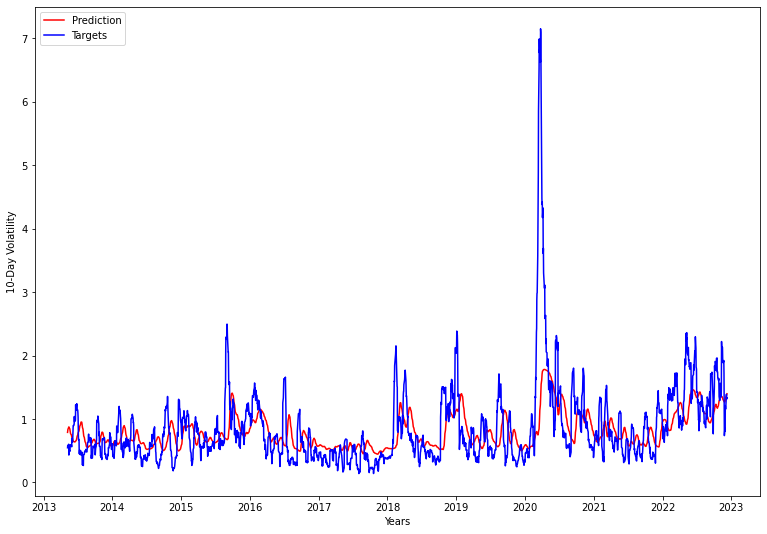

In [29]:
torch.cuda.empty_cache()
gc.collect()

val_preds, val_targets, val_loss = predict(val_loader, model)

test_preds, test_targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

df = data.copy()
df = df.tail(len(test_preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = test_preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, test_preds, label="Prediction", color="red")
plt.plot(df.index, test_targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

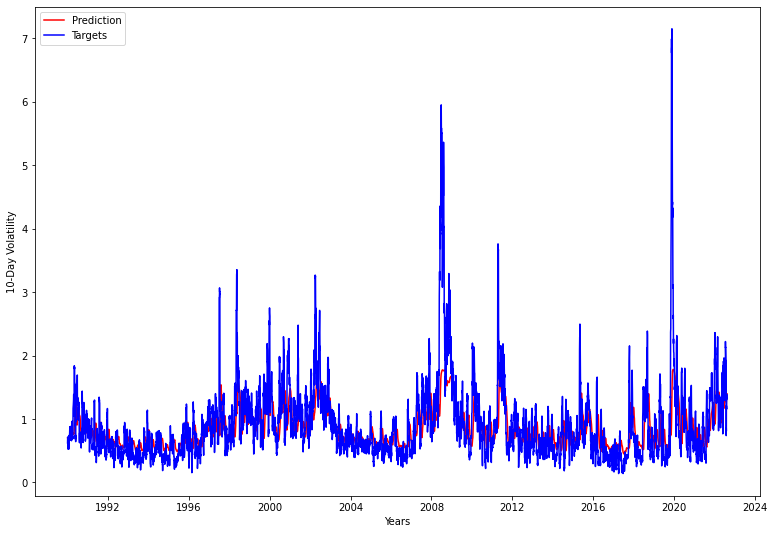

Whole dataset loss : 0.2634219


In [30]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Whole dataset loss : {:.07}'.format(loss)
print(loss)